In [1]:
import os
import numpy as np
import time
from copy import deepcopy
import matplotlib.pyplot as plt

from scipy.special import kv
from scipy.special import kn
from scipy.special import gamma as Gamma

In [2]:
import sys
list_syspaths = ['/Users/adityakrishna/Documents/UW_PHD/2025-infotaxis/otto']
list_syspaths+=sys.path
sys.path = list_syspaths

from otto.otto.visualize import visualize as viz
from otto.otto.classes.sourcetracking import SourceTracking as env
from otto.otto.classes.visualization import Visualization
from otto.otto.classes.heuristicpolicy import HeuristicPolicy

In [3]:
viz.DIR_OUTPUTS

'/Users/adityakrishna/Documents/UW_PHD/2025-infotaxis/otto/outputs'

In [4]:
if not os.path.isdir(viz.DIR_OUTPUTS):
    os.makedirs(viz.DIR_OUTPUTS)

start_time_0 = time.monotonic()

In [5]:
EPSILON = 1e-10
EPSILON_CHOICE = EPSILON

RUN_NAME = time.strftime("%Y%m%d-%H%M%S")
N_DIMS = 2

In [6]:
def infotaxis(myenv):
    """Original infotaxis, from Vergassola, Villermaux and Shraiman (Nature 2007)"""
    delta_entropy = np.ones(myenv.Nactions) * float("inf")
    for a in range(myenv.Nactions):
        # moving agent
        agent_, move_possible = myenv._move(a, myenv.agent)
        if move_possible:
            # calculating p_end
            p_source_ = deepcopy(myenv.p_source)
            p_end = p_source_[tuple(agent_)]
            if p_end > 1 - EPSILON:
                # force the agent to go the source (essentially never used)
                expected_S = -EPSILON
            else:
                # updating p_source for not finding source
                p_source_[tuple(agent_)] = 0
                if np.sum(p_source_) > EPSILON:
                    p_source_ /= np.sum(p_source_)

                # extracting the evidence matrix for Bayesian inference
                p_evidence = myenv._extract_N_from_2N(input=myenv.p_Poisson, origin=agent_)

                # updating p_source_ by Bayesian inference
                p_source_ = p_source_ * p_evidence
                p_hit = np.sum(p_source_, axis=tuple(range(1, p_source_.ndim)))
                for h in range(myenv.Nhits):
                    if p_hit[h] > EPSILON:
                        p_source_[h] /= p_hit[h]

                # calculating entropy
                entropy_ = myenv._entropy(p_source_,
                                            axes=tuple(range(1, p_source_.ndim)))
                expected_S = (1.0 - p_end) * np.sum(p_hit * entropy_)

            delta_entropy[a] = expected_S - myenv.entropy

    action_chosen = np.argwhere(np.abs(delta_entropy - np.min(delta_entropy)) < EPSILON_CHOICE).flatten()[0]

    return action_chosen, -delta_entropy

In [99]:
"""Main function to run and render an episode."""
print("*** initializing env...")

myenv = env(
    Ndim=N_DIMS,
    lambda_over_dx=viz.LAMBDA_OVER_DX,
    R_dt=viz.R_DT,
    norm_Poisson=viz.NORM_POISSON,
    Ngrid=viz.N_GRID,
    Nhits=viz.N_HITS,
    draw_source=viz.DRAW_SOURCE,
)
print("N_DIMS = " + str(myenv.Ndim))
print("LAMBDA_OVER_DX = " + str(myenv.lambda_over_dx))
print("R_DT = " + str(myenv.R_dt))
print("NORM_POISSON = " + myenv.norm_Poisson)
print("N_GRID = " + str(myenv.N))
print("N_HITS = " + str(myenv.Nhits))
print("DRAW_SOURCE = " + str(myenv.draw_source))

mypol = HeuristicPolicy(
    env=myenv,
    policy=viz.POLICY,
    steps_ahead=viz.STEPS_AHEAD,
)
print("POLICY = " + str(mypol.policy_index) + " (" + mypol.policy_name + ")")
print("STEPS_AHEAD = " + str(mypol.steps_ahead))

*** initializing env...
N_DIMS = 2
LAMBDA_OVER_DX = 2.0
R_DT = 2.0
NORM_POISSON = Euclidean
N_GRID = 37
N_HITS = 4
DRAW_SOURCE = True
POLICY = 0 (infotaxis)
STEPS_AHEAD = 1


In [100]:
pos0 = myenv.agent
pos0

[18, 18]

In [101]:
myenv.agent, myenv.source

([18, 18], (35, 3))

In [102]:
print(f"*** running... {viz.VISU_MODE} {viz.DRAW_SOURCE} {viz.ZERO_HIT}")

t = 0  # timestep
T_mean = 0
p_not_found_yet = 1   # proba the source has not been found yet
stop = 0

*** running... 2 True False


In [103]:
all_p_ends_for_a = np.empty((0, 4), dtype=int)
all_indexes = np.empty((0, 2), dtype=int)

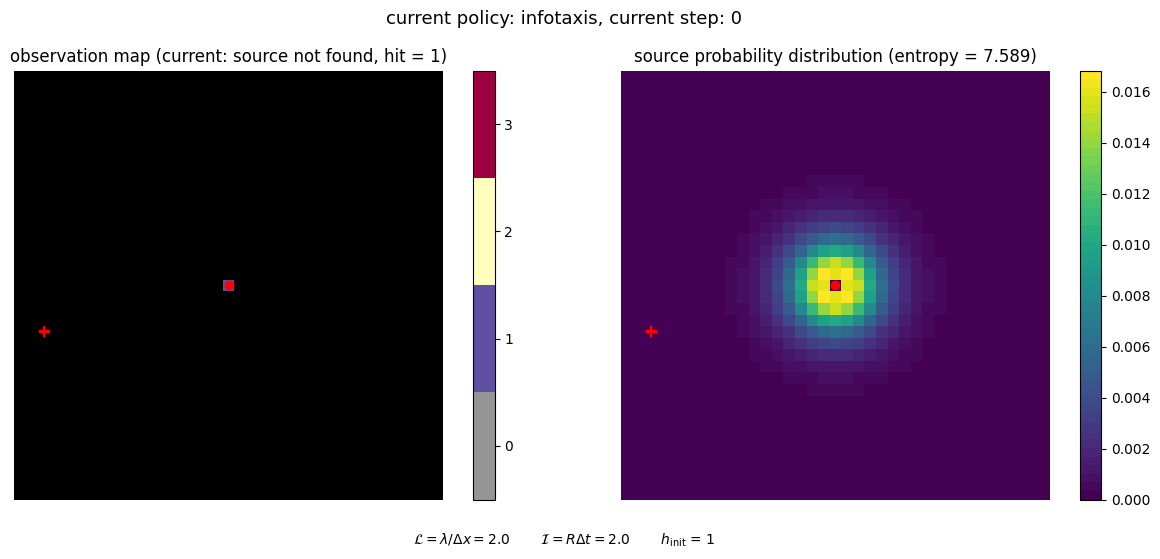

nstep:    1, action: 0, hits:   0, cum_hits:      0, p_not_found_yet: 1.00000000


<Figure size 640x480 with 0 Axes>

In [96]:
filename = os.path.join(viz.DIR_OUTPUTS, str(RUN_NAME))
myvisu = Visualization(
    myenv,
    live=True,
    filename=filename
)
toptext = "current policy: %s, current step: %d" % (mypol.policy_name, t)
myvisu.record_snapshot(num=t, toptext=toptext)

# choice of action
action, _ = infotaxis(myenv)

# step in myenv
forced_hit = None
hit, p_end, done = myenv.step(action, hit=forced_hit, quiet=False)

t += 1
T_mean += p_not_found_yet
p_not_found_yet *= 1 - p_end

print("nstep: %4d, action: %1d, hits: %3d, cum_hits: %6d, p_not_found_yet: %.8f"
        % (t, action, hit, myenv.cumulative_hits, p_not_found_yet))

In [ ]:
filename = os.path.join(viz.DIR_OUTPUTS, str(RUN_NAME))
myvisu = Visualization(
    myenv,
    live=True,
    filename=filename
)
toptext = "current policy: %s, current step: %d" % (mypol.policy_name, t)
myvisu.record_snapshot(num=t, toptext=toptext)

# choice of action
### This is infotaxis method start (action, _ = infotaxis(myenv))
delta_entropy = np.ones(myenv.Nactions) * float("inf")
p_ends_for_a = []
indexes = []
for a in range(myenv.Nactions):
    # moving agent
    agent_, move_possible = myenv._move(a, myenv.agent)
    if move_possible:
        # calculating p_end
        p_source_ = deepcopy(myenv.p_source)
        p_end = p_source_[tuple(agent_)]
        print(a, agent_, np.array(agent_) - np.array(myenv.agent), p_end)
        p_ends_for_a += [p_end]
        if p_end > 1 - EPSILON:
            # force the agent to go the source (essentially never used)
            expected_S = -EPSILON
        else:
            # updating p_source for not finding source
            p_source_[tuple(agent_)] = 0
            if np.sum(p_source_) > EPSILON:
                p_source_ /= np.sum(p_source_)

            # extracting the evidence matrix for Bayesian inference
            print(myenv.p_Poisson.shape, 2*myenv.N+1, 2*myenv.N-1)
            
            # extracting the evidence matrix for Bayesian inference
            # p_evidence = myenv._extract_N_from_2N(input=myenv.p_Poisson, origin=agent_)
            index = np.array([myenv.N] * myenv.Ndim) - agent_
            indexes += [index] 
            p_evidence = myenv.p_Poisson[..., index[0]:index[0] + myenv.N, index[1]:index[1] + myenv.N]

            # updating p_source_ by Bayesian inference
            p_source_ = p_source_ * p_evidence
            fig, ax = plt.subplots(1,8,figsize=(40,4))
            for i in range(8):
                if i<4:
                    cur_ax = ax[i]
                    cur_ax.imshow(myenv.p_Poisson[i,:,:])
                    cur_ax.scatter([index[0], index[0], index[0]+myenv.N, index[0]+myenv.N], 
                                [index[1], index[1]+myenv.N, index[1], index[1]+myenv.N], color='r')
                    cur_ax.scatter([myenv.N], [myenv.N], marker='x', color='r')
                else:
                    cur_ax = ax[i]
                    cur_ax.imshow(p_evidence[i%4,::,::])
                    cur_ax.scatter([pos0[0]], [pos0[1]], color='r')

            p_hit = np.sum(p_source_, axis=tuple(range(1, p_source_.ndim)))
            for h in range(myenv.Nhits):
                if p_hit[h] > EPSILON:
                    p_source_[h] /= p_hit[h]

            # calculating entropy
            entropy_ = myenv._entropy(p_source_,
                                        axes=tuple(range(1, p_source_.ndim)))
            expected_S = (1.0 - p_end) * np.sum(p_hit * entropy_)

        delta_entropy[a] = expected_S - myenv.entropy

all_p_ends_for_a = np.vstack([all_p_ends_for_a, (np.array(p_ends_for_a))])
all_indexes = np.vstack([all_indexes, (np.array(indexes))])
action = np.argwhere(np.abs(delta_entropy - np.min(delta_entropy)) < EPSILON_CHOICE).flatten()[0]
### This is infotaxis method end

# step in myenv
forced_hit = None
hit, p_end, done = myenv.step(action, hit=forced_hit, quiet=False)

t += 1
T_mean += p_not_found_yet
p_not_found_yet *= 1 - p_end

print("nstep: %4d, action: %1d, hits: %3d, cum_hits: %6d, p_not_found_yet: %.8f"
        % (t, action, hit, myenv.cumulative_hits, p_not_found_yet))

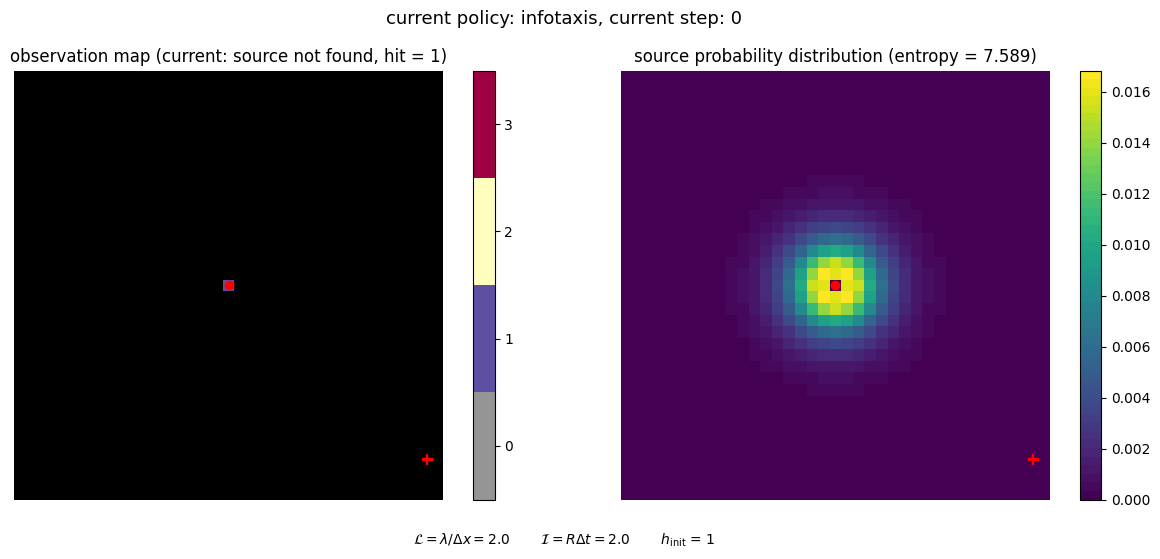

0 [17, 18] [-1  0] 0.016108412280649118
(4, 75, 75) 75 73
1 [19, 18] [1 0] 0.016108412280649118
(4, 75, 75) 75 73
2 [18, 17] [ 0 -1] 0.016108412280649118
(4, 75, 75) 75 73
3 [18, 19] [0 1] 0.016108412280649118
(4, 75, 75) 75 73
nstep:    1, action: 0, hits:   0, cum_hits:      0, p_not_found_yet: 1.00000000


<Figure size 640x480 with 0 Axes>

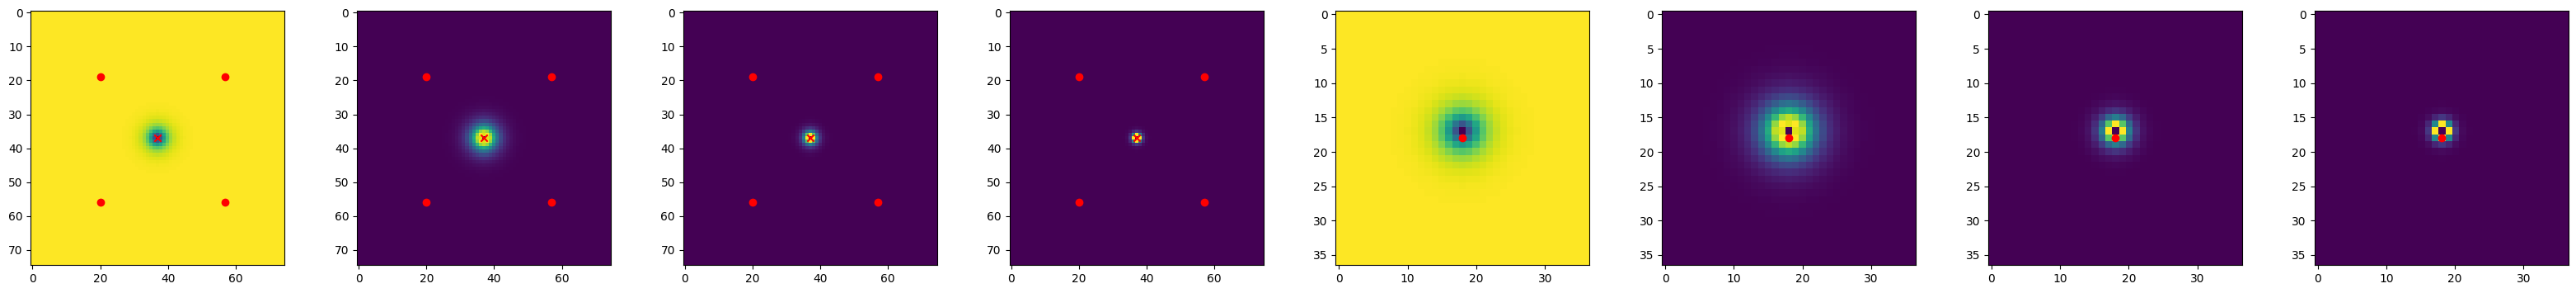

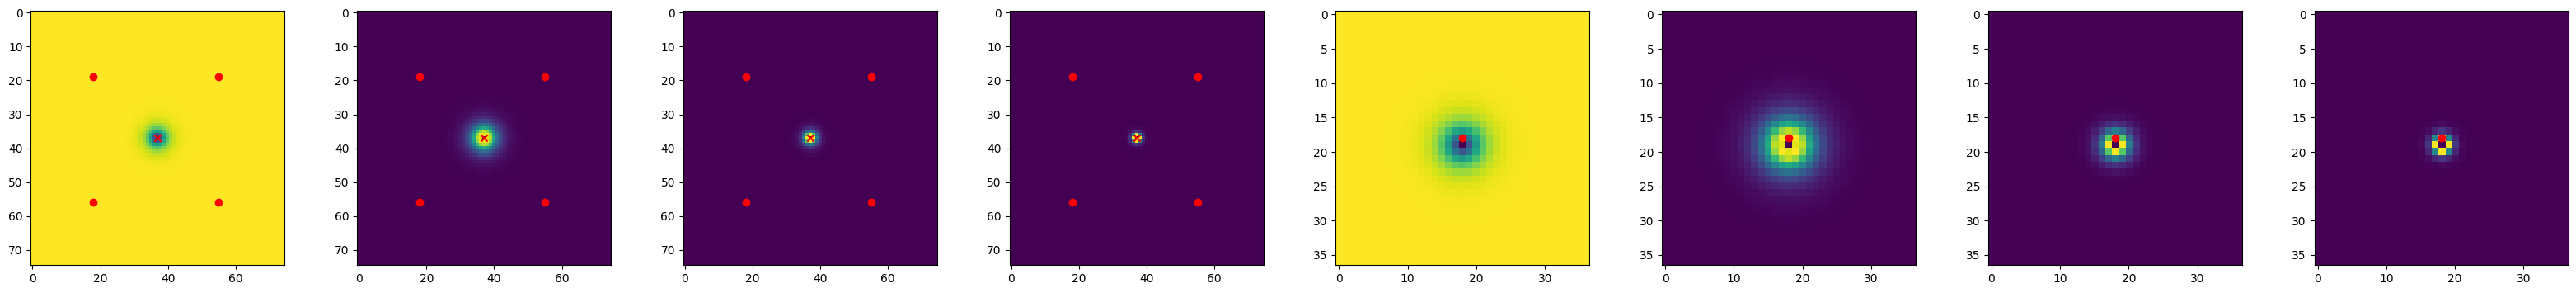

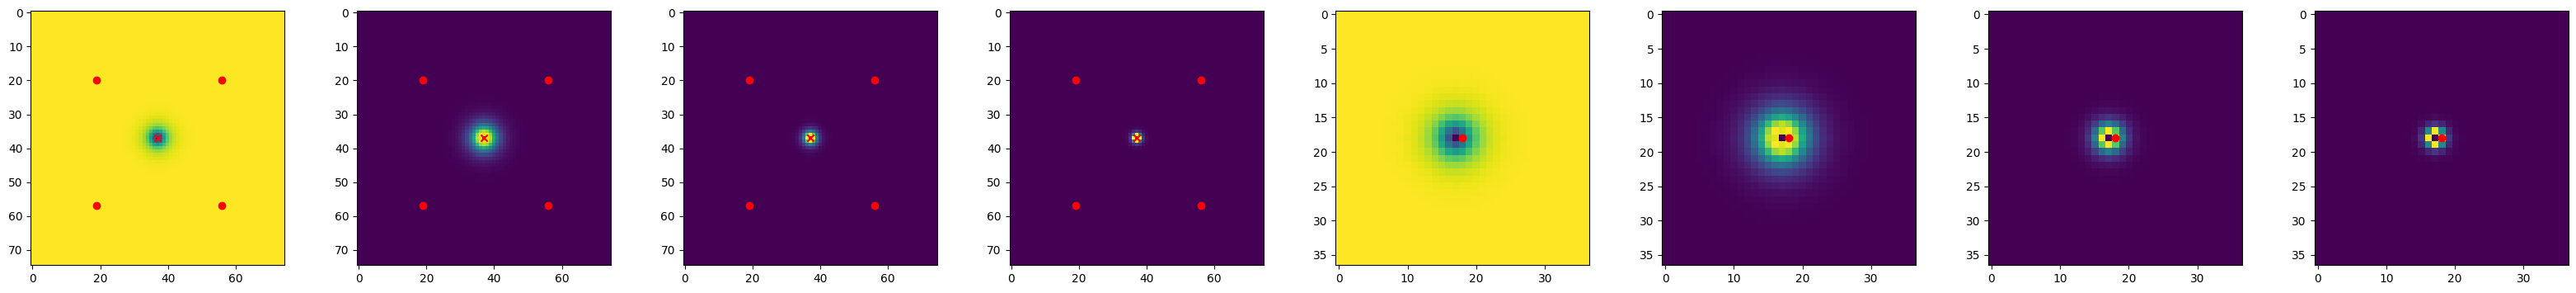

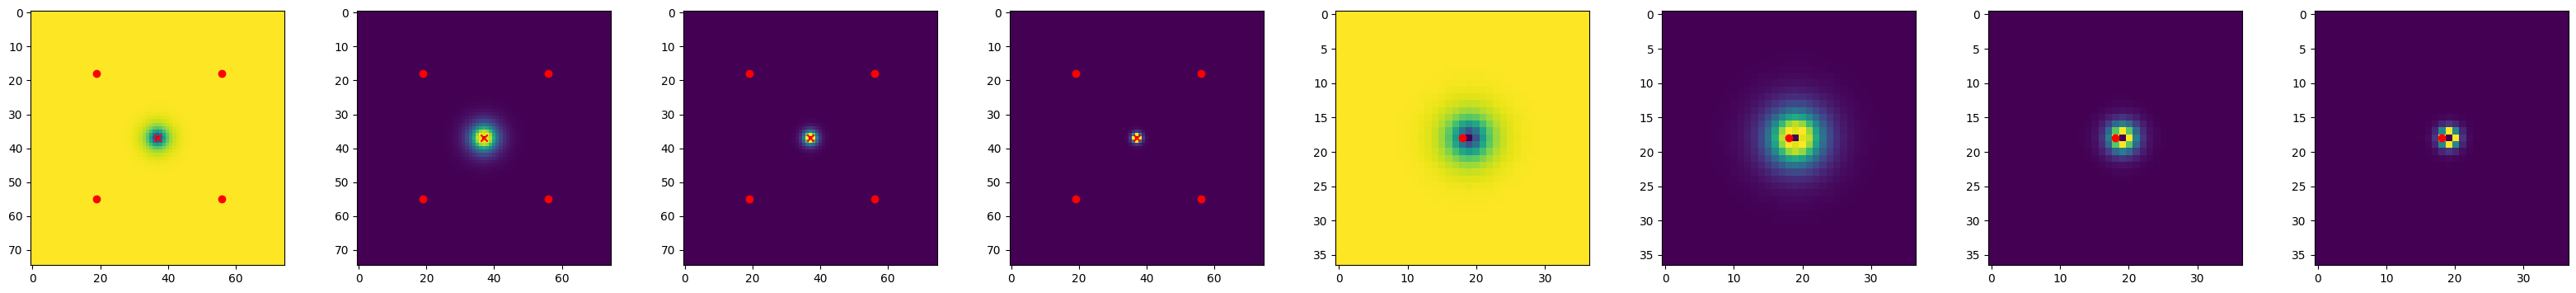

In [ ]:
filename = os.path.join(viz.DIR_OUTPUTS, str(RUN_NAME))
myvisu = Visualization(
    myenv,
    live=True,
    filename=filename
)
toptext = "current policy: %s, current step: %d" % (mypol.policy_name, t)
myvisu.record_snapshot(num=t, toptext=toptext)

# choice of action
### This is infotaxis method start (action, _ = infotaxis(myenv))
delta_entropy = np.ones(myenv.Nactions) * float("inf")
p_ends_for_a = []
indexes = []
for a in range(myenv.Nactions):
    # moving agent
    agent_, move_possible = myenv._move(a, myenv.agent)
    if move_possible:
        # calculating p_end
        p_source_ = deepcopy(myenv.p_source)
        p_end = p_source_[tuple(agent_)]
        print(a, agent_, np.array(agent_) - np.array(myenv.agent), p_end)
        p_ends_for_a += [p_end]
        if p_end > 1 - EPSILON:
            # force the agent to go the source (essentially never used)
            expected_S = -EPSILON
        else:
            # updating p_source for not finding source
            p_source_[tuple(agent_)] = 0
            if np.sum(p_source_) > EPSILON:
                p_source_ /= np.sum(p_source_)

            # extracting the evidence matrix for Bayesian inference
            print(myenv.p_Poisson.shape, 2*myenv.N+1, 2*myenv.N-1)
            
            # extracting the evidence matrix for Bayesian inference
            p_evidence = myenv._extract_N_from_2N(input=myenv.p_Poisson, origin=agent_)
            # index = np.array([myenv.N] * myenv.Ndim) - agent_
            # indexes += [index] 
            # p_evidence = myenv.p_Poisson[..., index[0]:index[0] + myenv.N, index[1]:index[1] + myenv.N]

            # updating p_source_ by Bayesian inference
            p_source_ = p_source_ * p_evidence
            # fig, ax = plt.subplots(1,8,figsize=(40,4))
            # for i in range(8):
            #     if i<4:
            #         cur_ax = ax[i]
            #         cur_ax.imshow(myenv.p_Poisson[i,:,:])
            #         cur_ax.scatter([index[0], index[0], index[0]+myenv.N, index[0]+myenv.N], 
            #                     [index[1], index[1]+myenv.N, index[1], index[1]+myenv.N], color='r')
            #         cur_ax.scatter([myenv.N], [myenv.N], marker='x', color='r')
            #     else:
            #         cur_ax = ax[i]
            #         cur_ax.imshow(p_evidence[i%4,::,::])
            #         cur_ax.scatter([pos0[0]], [pos0[1]], color='r')

            p_hit = np.sum(p_source_, axis=tuple(range(1, p_source_.ndim)))
            for h in range(myenv.Nhits):
                if p_hit[h] > EPSILON:
                    p_source_[h] /= p_hit[h]

            # calculating entropy
            entropy_ = myenv._entropy(p_source_,
                                        axes=tuple(range(1, p_source_.ndim)))
            expected_S = (1.0 - p_end) * np.sum(p_hit * entropy_)

        delta_entropy[a] = expected_S - myenv.entropy

all_p_ends_for_a = np.vstack([all_p_ends_for_a, (np.array(p_ends_for_a))])
all_indexes = np.vstack([all_indexes, (np.array(indexes))])
action = np.argwhere(np.abs(delta_entropy - np.min(delta_entropy)) < EPSILON_CHOICE).flatten()[0]
### This is infotaxis method end

# step in myenv
forced_hit = None
hit, p_end, done = myenv.step(action, hit=forced_hit, quiet=False)

t += 1
T_mean += p_not_found_yet
p_not_found_yet *= 1 - p_end

print("nstep: %4d, action: %1d, hits: %3d, cum_hits: %6d, p_not_found_yet: %.8f"
        % (t, action, hit, myenv.cumulative_hits, p_not_found_yet))

In [20]:
all_indexes

array([[10,  9],
       [ 8,  9],
       [ 9, 10],
       [ 9,  8]])

In [299]:
myenv.p_Poisson[...,19:19+37,18:18+37].shape

(4, 37, 37)

In [295]:
np.array([myenv.N] * myenv.Ndim) - agent_

array([19, 18])

In [281]:
all_p_ends_for_a

array([[1.61084123e-02, 1.61084123e-02, 1.61084123e-02, 1.61084123e-02],
       [5.28706246e-03, 0.00000000e+00, 5.86785285e-03, 5.86785285e-03],
       [2.32885580e-03, 2.66130427e-03, 3.25504353e-03, 0.00000000e+00],
       [1.27526197e-03, 1.72699605e-03, 1.88596134e-03, 0.00000000e+00],
       [0.00000000e+00, 1.80263478e-03, 1.01630392e-03, 3.57492198e-04],
       [0.00000000e+00, 1.71433755e-03, 8.03796947e-04, 7.95757787e-04],
       [0.00000000e+00, 1.38621103e-03, 6.68003787e-04, 9.55021633e-04],
       [0.00000000e+00, 9.94756067e-04, 5.17820405e-04, 7.99036828e-04],
       [1.15828205e-04, 5.71170048e-04, 0.00000000e+00, 1.01903228e-03],
       [3.26546144e-04, 5.24543262e-04, 0.00000000e+00, 1.26721313e-03],
       [5.80007893e-04, 5.34101849e-04, 0.00000000e+00, 1.35338355e-03],
       [7.41898151e-04, 5.14041225e-04, 0.00000000e+00, 1.23396229e-03],
       [6.04360897e-02, 3.73000890e-02, 0.00000000e+00, 8.23125226e-02],
       [1.99077494e-01, 1.20049149e-01, 0.00000000e

In [ ]:
if done:
    # message = "success: source found"
    stop = 1
elif p_not_found_yet < viz.STOP_p or p_end > 1 - viz.EPSILON:
    # message = "success: source almost surely found (p_not_found_yet = " + str(round(p_not_found_yet, 8)) + ")"
    stop = 1
elif t > viz.STOP_t - 1:
    # message = "failure: max number of iterations reached (nb it = " + str(t) + ")"
    stop = 2
elif myenv.agent_stuck:
    # message = "failure: agent is stuck"
    stop = 3

In [389]:
toptext = "current policy: %s, current step: %d" % (mypol.policy_name, t)

myvisu.record_snapshot(num=t, toptext=toptext)
exitcode = myvisu.make_video(frame_rate=viz.FRAME_RATE, keep_frames=viz.KEEP_FRAMES)
if exitcode == 0:
    print(">>> Video saved in: " + str(filename) + "_video.mp4")
else:
    print(">>> Frames have been saved in: " + str(filename) + "_frames")

<Figure size 640x480 with 0 Axes>

>>> Video saved in: /Users/adityakrishna/Documents/UW_PHD/EE508/FinalProject/otto/outputs/20250314-194747_video.mp4
